In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Embedding, LSTM, GRU, SimpleRNN, Dense, TimeDistributed, Concatenate, Attention
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

In [45]:
# Loading the DATA
train_data = pd.read_csv("kn.translit.sampled.train.tsv", sep='\t', header=None)
test_data =  pd.read_csv("kn.translit.sampled.test.tsv", sep='\t', header = None)
val_data = pd.read_csv("kn.translit.sampled.dev.tsv", sep='\t', header= None)

In [46]:
# Filtering the data
train_data = train_data.dropna()
test_data = test_data.dropna()
val_data = val_data.dropna()

In [47]:
# Creating Vocubalory
X = [list('\t'+ w +'\n') for w in np.array(train_data[1])] # Input Sequence
Y = [list('\t'+ w +'\n') for w in np.array(train_data[0])] # Traget Sequence

kannada_vocab = set() # Set avoids duplicates
eng_vocab = set() # Set avoids duplicates

for word in X:
    for char in word:
        eng_vocab.add(char)

for word in Y:
    for char in word:
        kannada_vocab.add(char)

kannada_vocab_list = sorted(list(kannada_vocab))
eng_vocab_list = sorted(list(eng_vocab))

In [48]:
# Preparing Data
num_input_tokens = len(eng_vocab_list)
num_output_tokens = len(kannada_vocab_list)

# Mapping character to index
input_token_index = {}
for i, char in enumerate(eng_vocab_list):
    input_token_index[char] = i

output_token_index = {}
for i, char in enumerate(kannada_vocab_list):
    output_token_index[char] = i

# Mapping index to character:
# Inverting the previous dictionaries to avoid searching operations while decoding

input_index_token = {i: char for char, i in input_token_index.items()}
output_input_token = {i: char for char, i in output_token_index.items()}

max_input_seq_length = max([len(seq) for seq in X])
max_output_seq_length = max([len(seq) for seq in Y])

In [49]:
def prepare(x, y):
    # Converts list of characters -> list of indexes and provides the corresponding teacher forcing targets
    decoder_target = np.zeros((len(x), max_output_seq_length, num_output_tokens), dtype="float32")

    for i, seq in enumerate(y):
        for t, char in enumerate(seq):
            if t > 0 :
                decoder_target[i, t-1, output_token_index[char]] = 1.0
        decoder_target[i, t:, output_token_index["\n"]] = 1.0

    encoder_samples = [[input_token_index[letter] for letter in seq] for seq in x]
    decoder_samples = [[output_token_index[letter] for letter in seq] for seq in y]

    return encoder_samples, decoder_samples, decoder_target

In [50]:
X_train = [list('\t'+ w +'\n') for w in np.array(train_data[1])] # Input Sequence
Y_train = [list('\t'+ w +'\n') for w in np.array(train_data[0])] # Traget Sequence

X_test = [list('\t'+ w +'\n') for w in np.array(test_data[1])] # Input Sequence
Y_test = [list('\t'+ w +'\n') for w in np.array(test_data[0])] # Traget Sequence

X_val = [list('\t'+ w +'\n') for w in np.array(val_data[1])] # Input Sequence
Y_val = [list('\t'+ w +'\n') for w in np.array(val_data[0])] # Traget Sequence

In [51]:
encoder_train, decoder_train, decoder_target_train = prepare(X_train, Y_train)
encoder_test, decoder_test, decoder_target_test = prepare(X_test, Y_test)
encoder_val, decoder_val, decoder_target_val = prepare(X_val, Y_val)

In [52]:
def pad(List, max_length):
    return sequence.pad_sequences(List, maxlen=max_length, padding="post")

In [53]:
encoder_train = pad(encoder_train, max_input_seq_length)
encoder_test = pad(encoder_test, max_input_seq_length)
encoder_val = pad(encoder_val, max_input_seq_length)

decoder_train = pad(decoder_train, max_output_seq_length)
decoder_test = pad(decoder_test, max_output_seq_length)
decoder_val = pad(decoder_val, max_output_seq_length)

In [54]:

def Eng2Kan_with_attention(encoder_tokens, decoder_tokens, embedding_dim, hidden_dim,
                           max_input_seq_length, max_output_seq_length,
                           no_encoder_layers, no_decoder_layers, dropouts=0.1, cell_type="gru"):

    cell_type = cell_type.lower()

    # Encoder
    encoder_inputs = Input(shape=(None,), name="encoder_input")
    encoder_embed = Embedding(encoder_tokens, embedding_dim, input_length=max_input_seq_length, name="encoder_embedding")(encoder_inputs)

    encoder_outputs = encoder_embed
    encoder_states = []
    for i in range(no_encoder_layers):
        if cell_type == "lstm":
            encoder_outputs, state_h, state_c = LSTM(hidden_dim, return_sequences=True, return_state=True, dropout=dropouts)(encoder_outputs)
            encoder_states = [state_h, state_c]
        elif cell_type == "gru":
            encoder_outputs, state_h = GRU(hidden_dim, return_sequences=True, return_state=True, dropout=dropouts)(encoder_outputs)
            encoder_states = [state_h]
        else:
            encoder_outputs, state_h = SimpleRNN(hidden_dim, return_sequences=True, return_state=True, dropout=dropouts)(encoder_outputs)
            encoder_states = [state_h]

    # Decoder
    decoder_inputs = Input(shape=(None,), name="decoder_input")
    decoder_embed = Embedding(decoder_tokens, embedding_dim, input_length=max_output_seq_length, name="decoder_embedding")(decoder_inputs)

    decoder_rnn = None
    decoder_states = []
    if cell_type == "lstm":
        decoder_rnn = LSTM(hidden_dim, return_sequences=True, return_state=True, dropout=dropouts)
        decoder_outputs, _, _ = decoder_rnn(decoder_embed, initial_state=encoder_states)
    elif cell_type == "gru":
        decoder_rnn = GRU(hidden_dim, return_sequences=True, return_state=True, dropout=dropouts)
        decoder_outputs, _ = decoder_rnn(decoder_embed, initial_state=encoder_states)
    else:
        decoder_rnn = SimpleRNN(hidden_dim, return_sequences=True, return_state=True, dropout=dropouts)
        decoder_outputs, _ = decoder_rnn(decoder_embed, initial_state=encoder_states)

    # Attention mechanism
    attention_layer = Attention(name="attention_layer")
    context_vector, attention_weights = attention_layer([decoder_outputs, encoder_outputs], return_attention_scores=True)  # (batch_size, targ_seq_len, hidden)

    attention_output = Lambda(lambda x: x, name="attention_weights")(attention_weights)

    # Concatenate context with decoder outputs
    decoder_combined_context = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, context_vector])

    # Final output layer
    output_layer = TimeDistributed(Dense(decoder_tokens, activation='softmax'), name="output_layer")
    decoder_final_output = output_layer(decoder_combined_context)

    model = Model([encoder_inputs, decoder_inputs], decoder_final_output)
    attention_extractor = Model(inputs=[encoder_inputs, decoder_inputs], outputs=attention_output)

    return model, attention_extractor

In [55]:
encoder_tokens = num_input_tokens
decoder_tokens = num_output_tokens

embedding_dim = 12
hidden_dim = 256
no_encoder_layers = 3
no_decoder_layers = 2
dropout = 0.2
cell = "lstm"

In [56]:
model, attention_extractor = Eng2Kan_with_attention(encoder_tokens, decoder_tokens, embedding_dim, hidden_dim, max_input_seq_length,
                max_output_seq_length, no_decoder_layers, no_decoder_layers, dropouts=dropout,cell_type=cell)

In [57]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 12)  │        336 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, None,     │    275,456 │ encoder_embeddin… │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 12)  │        756 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, None,     │    525,312 │ lstm_6[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, None,     │    275,456 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ lstm_7[0][1],     │
│                     │ 256), (None,      │            │ lstm_7[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │          0 │ lstm_8[0][0],     │
│ (Attention)         │ 256), (None,      │            │ lstm_7[0][0]      │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_8[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, None, 63)  │     32,319 │ concat_layer[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,109,635 (4.23 MB)

 Trainable params: 1,109,635 (4.23 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
attention_extractor.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 12)  │        336 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, None,     │    275,456 │ encoder_embeddin… │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 12)  │        756 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, None,     │    525,312 │ lstm_6[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, None,     │    275,456 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ lstm_7[0][1],     │
│                     │ 256), (None,      │            │ lstm_7[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │          0 │ lstm_8[0][0],     │
│ (Attention)         │ 256), (None,      │            │ lstm_7[0][0]      │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, None,      │          0 │ attention_layer[… │
│ (Lambda)            │ None)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,077,316 (4.11 MB)

 Trainable params: 1,077,316 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])
batch_size = 32
epochs = 10

In [60]:
class Word_Accuracy(tf.keras.callbacks.Callback):
    def __init__(self, encoder_cv, decoder_cv, inv_target_token_index, max_length_y, sample_size=None):
        super().__init__()
        self.encoder_val = encoder_cv
        self.decoder_val = decoder_cv
        self.inv_target_token_index = inv_target_token_index
        self.max_output_seq_length = max_length_y
        self.sample_size = sample_size  # optional

    def on_epoch_end(self, epoch, logs=None):
        if self.sample_size:
            indices = np.random.choice(len(self.encoder_val), self.sample_size, replace=False)
            enc = self.encoder_val[indices]
            dec = self.decoder_val[indices]
        else:
            enc = self.encoder_val
            dec = self.decoder_val

        predictions = self.model.predict([enc, dec], verbose=0)
        count = 0

        for i in range(len(predictions)):
            actual_out = re.sub(r'\t|\n', '', ''.join(
                [self.inv_target_token_index[dec[i][j]] for j in range(self.max_output_seq_length)]
            ))
            predicted_out = re.sub(r'\t|\n', '', ''.join(
                [self.inv_target_token_index[np.argmax(predictions[i][j])] for j in range(self.max_output_seq_length)]
            ))

            if actual_out == predicted_out:
                count += 1

        acc = count / len(predictions)
        logs["WordAccuracy"] = acc
        print(f"\nEpoch {epoch + 1}: Word-level Accuracy = {acc:.4f}")


In [61]:
word_acc_cb = Word_Accuracy(
    encoder_cv=encoder_val,
    decoder_cv=decoder_val,
    inv_target_token_index=output_input_token,
    max_length_y=max_output_seq_length
)

history = model.fit(
    [encoder_train, decoder_train],
    decoder_target_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([encoder_val, decoder_val], decoder_target_val),
    callbacks=[word_acc_cb],
    verbose=1
)


Epoch 1/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7206 - loss: 1.1043
Epoch 1: Word-level Accuracy = 0.0040
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.7207 - loss: 1.1041 - val_accuracy: 0.8513 - val_loss: 0.5214 - WordAccuracy: 0.0040
Epoch 2/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8982 - loss: 0.3576
Epoch 2: Word-level Accuracy = 0.3085
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8982 - loss: 0.3575 - val_accuracy: 0.9546 - val_loss: 0.1543 - WordAccuracy: 0.3085
Epoch 3/10
1579/1582 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9626 - loss: 0.1277
Epoch 3: Word-level Accuracy = 0.4032
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9626 - loss: 0.1277 - val_accuracy: 0.9646 - val_loss: 0.1175 - WordAccuracy: 0.4032
Epoch 4/10
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9697 - loss: 0.0985
Epoch 4: Word-level Accuracy = 0.4339
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9

In [62]:
test_predictions = model.predict([encoder_test, decoder_test], verbose=0)

count = 0
inputs = []
actual_output = []
predicted = []
for i in range(len(test_predictions)):

    English_input = re.sub(r'\t|\n', '', ''.join(
        [input_index_token[encoder_test[i][j]] for j in range(max_output_seq_length)]
    ))
    actual_out = re.sub(r'\t|\n', '', ''.join(
        [output_input_token[decoder_test[i][j]] for j in range(max_output_seq_length)]
    ))
    predicted_out = re.sub(r'\t|\n', '', ''.join(
        [output_input_token[np.argmax(test_predictions[i][j])] for j in range(max_output_seq_length)]
    ))

    actual_output.append(actual_out)
    predicted.append(predicted_out)
    inputs.append(English_input)

    if actual_out == predicted_out:
        count += 1

acc = count / len(test_predictions)
print("Percentage of correct predictions for test dataset is",acc*100)

Percentage of correct predictions for test dataset is 51.38723741577487


In [63]:
# Saving the prediction of the Test data
df = pd.DataFrame({'Input':inputs, 'Target': actual_output, 'Predicted': predicted})

df.to_csv('predictions_attention.csv', index=False)

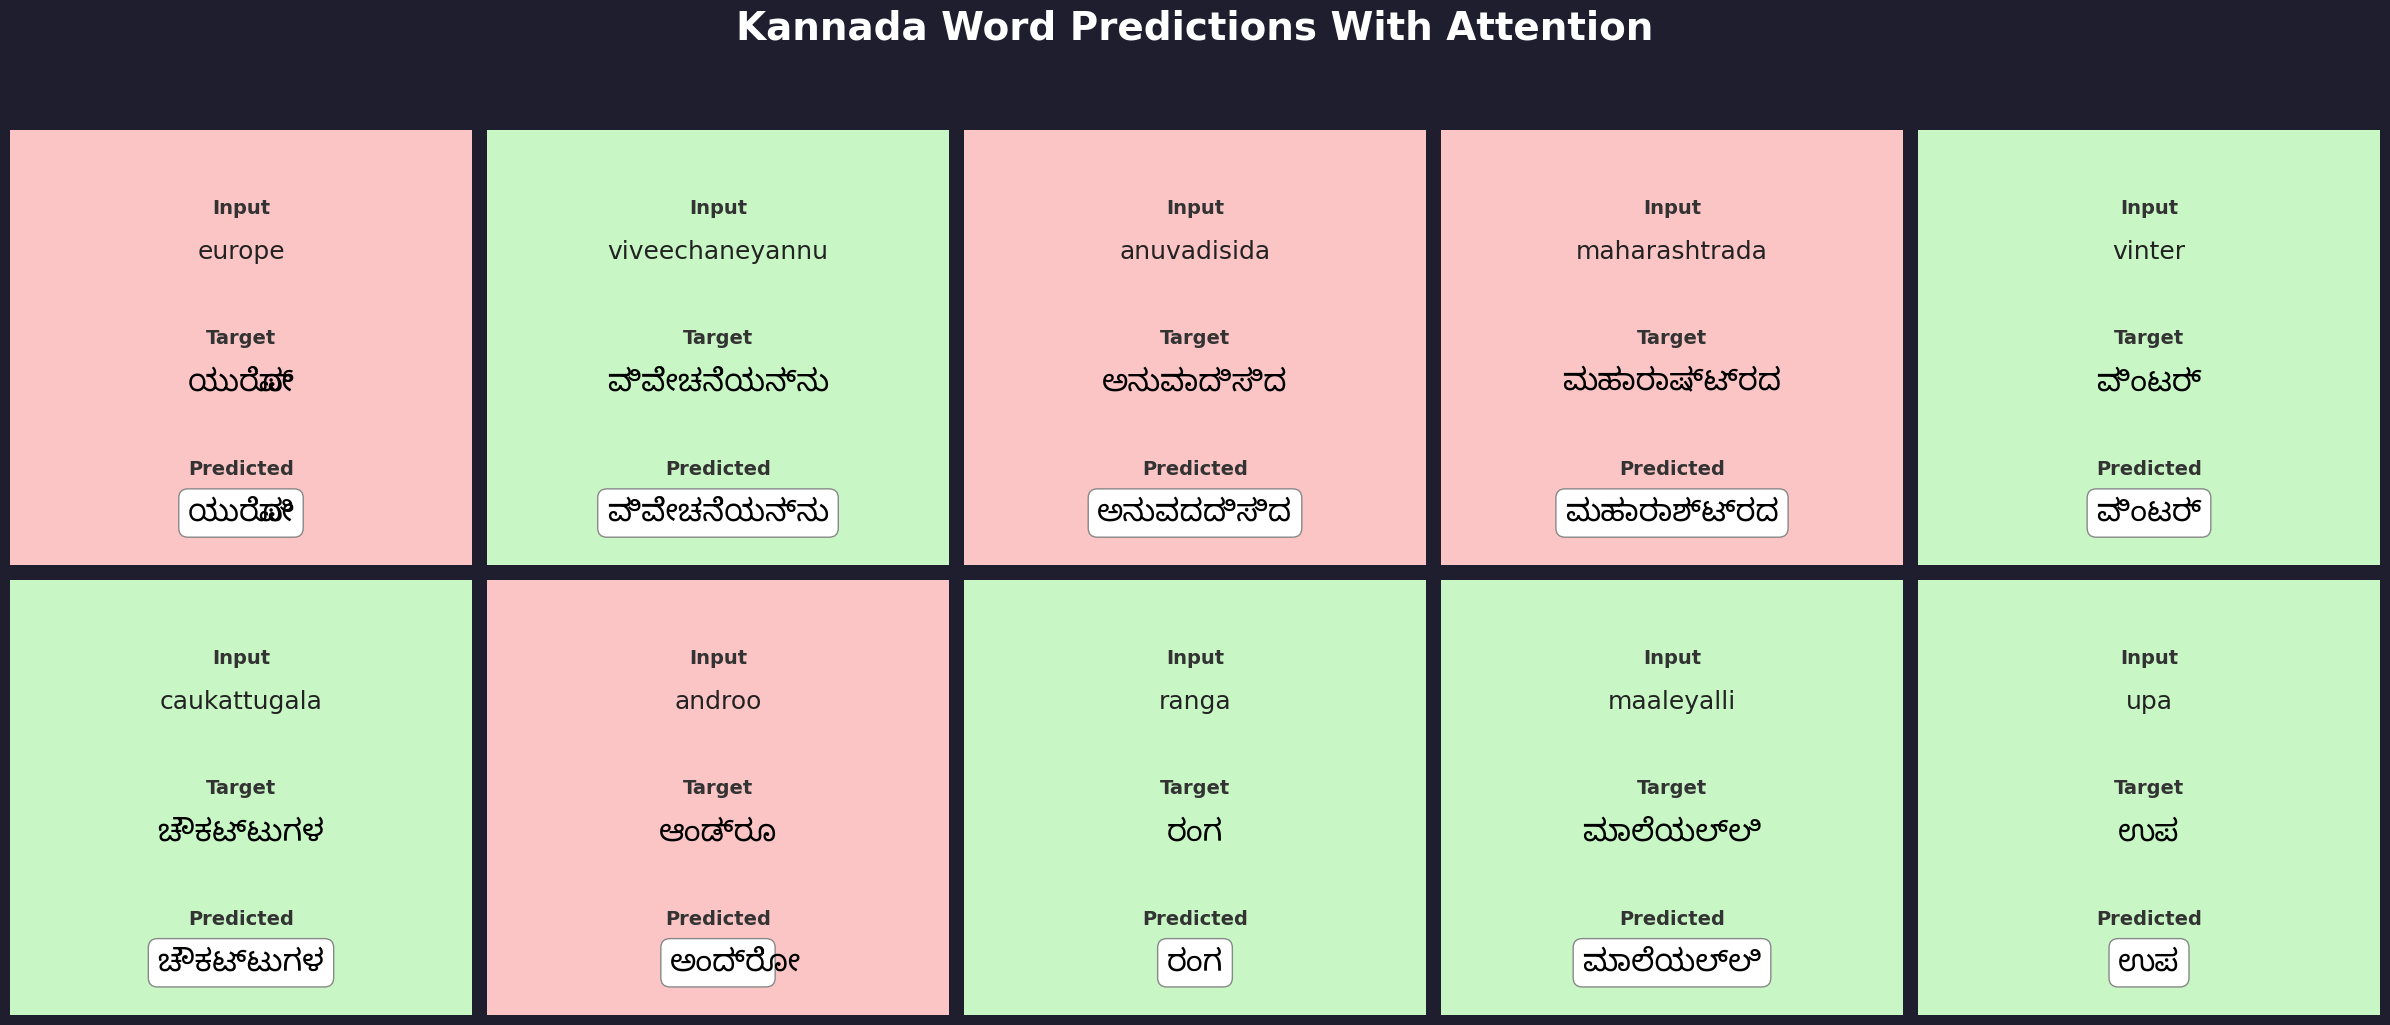

In [64]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, patches

df = pd.read_csv("predictions_attention.csv")
df.columns = ["Input", "Target", "Predicted"]
sample_df = df.sample(10, random_state=6).reset_index(drop=True)

kannada_font_path = "NotoSansKannada-VariableFont_wdth,wght.ttf"
font_prop = font_manager.FontProperties(fname=kannada_font_path)

fig, axs = plt.subplots(2, 5, figsize=(24, 10), facecolor="#1e1e2f")
axs = axs.flatten()

for i, row in sample_df.iterrows():
    ax = axs[i]
    ax.axis("off")

    input_text = row["Input"]
    target_text = row["Target"]
    predicted_text = row["Predicted"]

    correct = target_text == predicted_text
    box_color = "#c8f7c5" if correct else "#fbc5c5"  # Soft green/red background

    rect = patches.FancyBboxPatch(
        (0, 0), 1, 1,
        boxstyle="round,pad=0.05",
        edgecolor='none',
        facecolor=box_color,
        linewidth=1,
        transform=ax.transAxes,
        zorder=0,
        mutation_scale=0.02
    )
    ax.add_patch(rect)

    # Add texts
    ax.text(0.5, 0.82, f"Input", fontsize=14, ha='center', va='center', fontweight='bold', color="#333333")
    ax.text(0.5, 0.72, input_text, fontsize=18, ha='center', va='center', color="#222222")

    ax.text(0.5, 0.52, "Target", fontsize=14, ha='center', va='center', fontweight='bold', color="#333333")
    ax.text(0.5, 0.42, target_text, fontproperties=font_prop, fontsize=22, ha='center', va='center', color="#000000")

    ax.text(0.5, 0.22, "Predicted", fontsize=14, ha='center', va='center', fontweight='bold', color="#333333")
    ax.text(0.5, 0.12, predicted_text, fontproperties=font_prop, fontsize=22, ha='center', va='center',
            bbox=dict(facecolor="#ffffff", boxstyle="round,pad=0.3", edgecolor='#888888'))

plt.suptitle("Kannada Word Predictions With Attention", fontsize=28, color='white', fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [65]:
attn_weights = attention_extractor.predict([encoder_test, decoder_test])

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


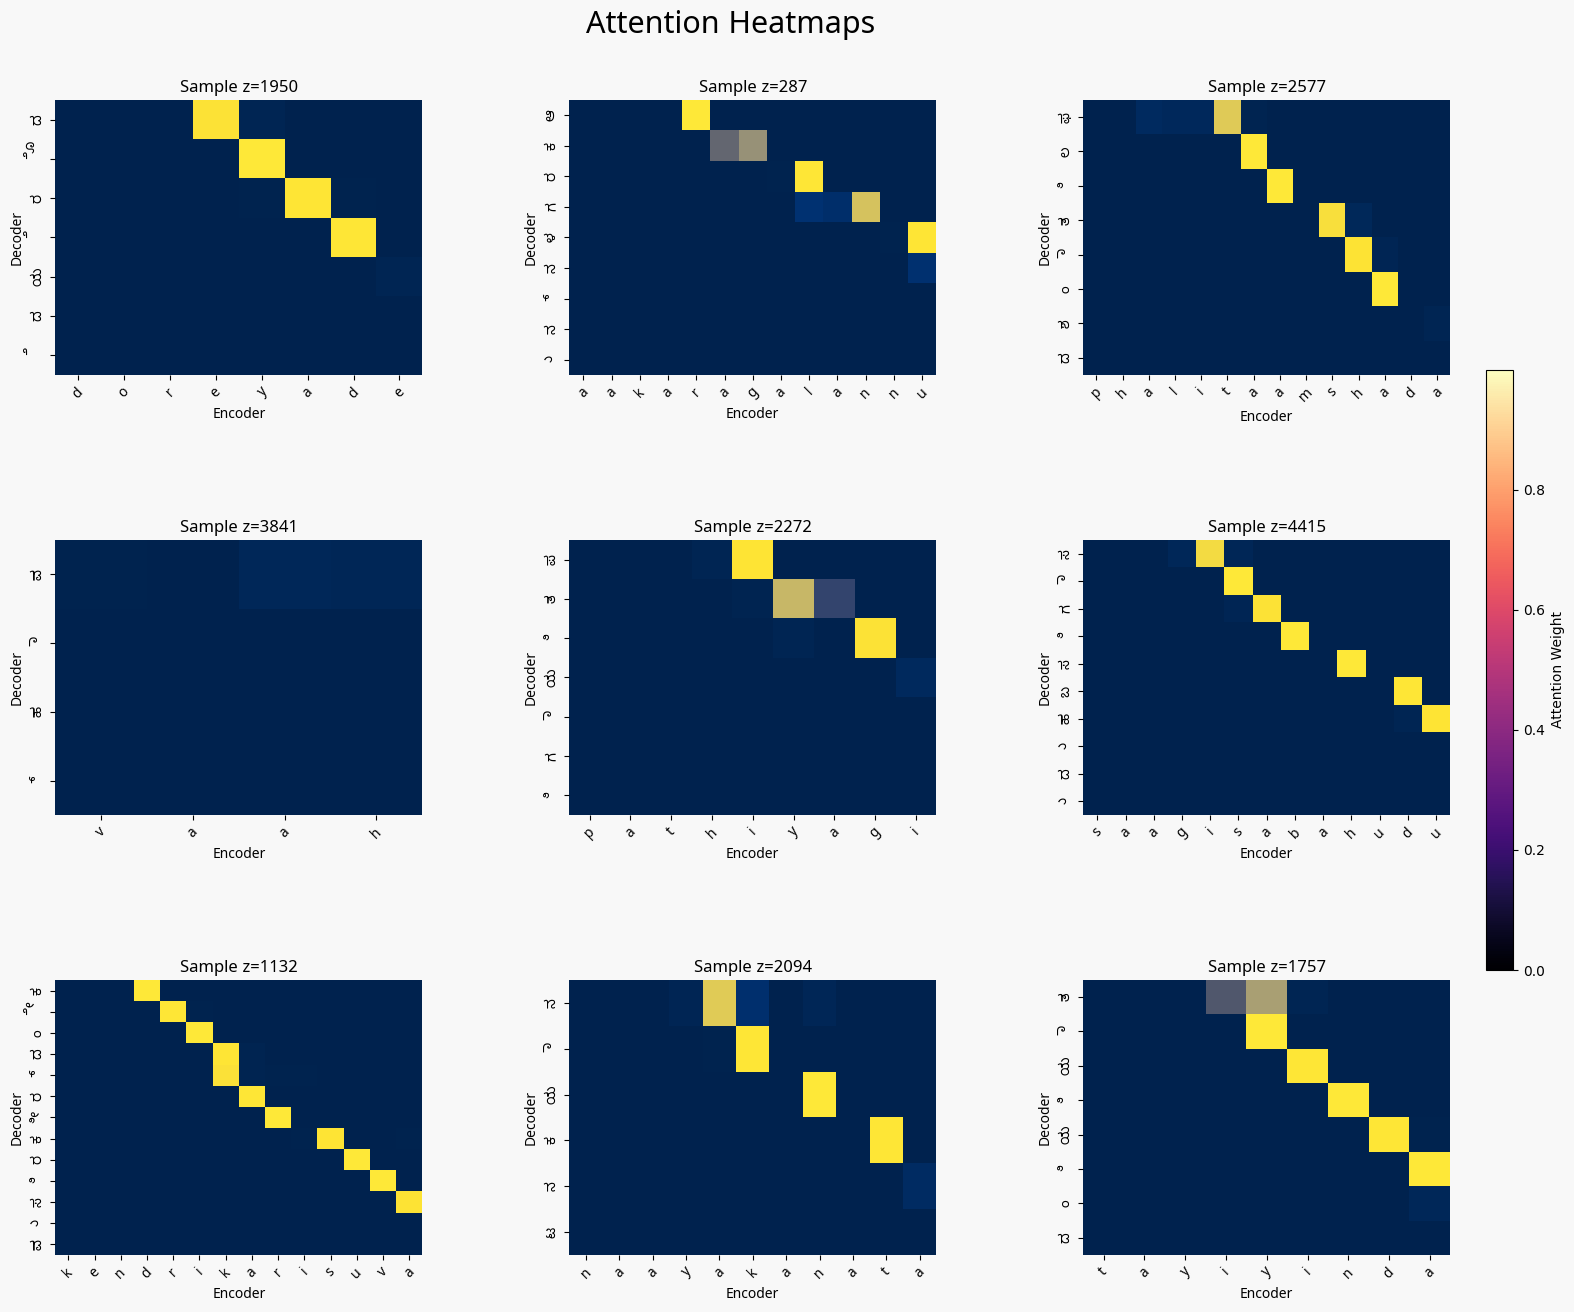

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from matplotlib import gridspec

# Load Kannada font
kannada_font_path = "NotoSansKannada-VariableFont_wdth,wght.ttf"
font_prop = font_manager.FontProperties(fname=kannada_font_path)

random_indices = np.random.choice(5000, size=9, replace=False)

def clean_token(tok):
    return tok.replace('\n', '').replace('\t', '').strip()

attention_matrices = []
encoder_labels = []
decoder_labels = []

for z in random_indices:
    encoder_tokens_raw = [input_index_token[tok] for tok in encoder_test[z]]
    decoder_tokens_raw = [output_input_token[tok] for tok in decoder_test[z]]

    encoder_tokens_clean = [clean_token(tok) for tok in encoder_tokens_raw]
    decoder_tokens_clean = [clean_token(tok) for tok in decoder_tokens_raw]

    encoder_valid_idx = [i for i, tok in enumerate(encoder_tokens_clean) if tok]
    decoder_valid_idx = [i for i, tok in enumerate(decoder_tokens_clean) if tok]

    encoder_filtered = [encoder_tokens_clean[i] for i in encoder_valid_idx]
    decoder_filtered = [decoder_tokens_clean[i] for i in decoder_valid_idx]

    attention_matrix = attn_weights[z]
    attention_matrix_filtered = attention_matrix[np.ix_(decoder_valid_idx, encoder_valid_idx)]

    attention_matrices.append(attention_matrix_filtered)
    encoder_labels.append(encoder_filtered)
    decoder_labels.append(decoder_filtered)

# Get global min and max for shared colorbar scale
vmin = min(mat.min() for mat in attention_matrices)
vmax = max(mat.max() for mat in attention_matrices)

fig, axes = plt.subplots(3, 3, figsize=(18, 15), facecolor='#f8f8f8')
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for idx, ax in enumerate(axes.flat):
    sns.heatmap(
        attention_matrices[idx],
        xticklabels=encoder_labels[idx],
        yticklabels=decoder_labels[idx],
        cmap='cividis',
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        cbar=False
    )
    ax.set_title(f"Sample z={random_indices[idx]}", fontproperties=font_prop, fontsize=12)
    ax.set_xlabel('Encoder', fontproperties=font_prop, fontsize=10)
    ax.set_ylabel('Decoder', fontproperties=font_prop, fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop)
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop)

# Add a single colorbar for all plots
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label='Attention Weight')

# Global title
plt.suptitle("Attention Heatmaps", fontproperties=font_prop, fontsize=22, y=0.94)
plt.show()


In [67]:
from IPython.display import HTML as html_print
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [68]:
def cstr(s,flag=False, color='black'):
  if flag:
    return "<text style=color:#000;background-color:{};font-size:31px>{} </text>".format(color, s)

  return "<text style=color:#000;background-color:{};font-size:30px>{} </text>".format(color, s)

# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) if ci != '#f42e2e' else cstr(ti,True,color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

In [78]:
def visualize(input_tokens, attention_matrix, target_char_index):
    text_colours = []

    for i in range(len(input_tokens)):
        attention_value = attention_matrix[target_char_index][i]
        text = (input_tokens[i], get_clr(attention_value))
        text_colours.append(text)

    print_color(text_colours)


In [79]:
def visualize_out(output_tokens, idx):
    text_colours = []
    for i in range(len(output_tokens)):
        if i == idx:
            text = (output_tokens[i], '#f42e2e')  # red highlight
        else:
            text = (output_tokens[i], '#85c2e1')  # default
        text_colours.append(text)
    print_color(text_colours)


In [94]:
def visualize_attention_for_sample(sample_index):
    encoder_tokens_raw = [input_index_token[tok] for tok in encoder_test[sample_index]]
    decoder_tokens_raw = [output_input_token[tok] for tok in decoder_test[sample_index]]

    encoder_tokens_clean = [clean_token(tok) for tok in encoder_tokens_raw]
    decoder_tokens_clean = [clean_token(tok) for tok in decoder_tokens_raw]

    encoder_valid_idx = [i for i, tok in enumerate(encoder_tokens_clean) if tok]
    decoder_valid_idx = [i for i, tok in enumerate(decoder_tokens_clean) if tok]

    encoder_filtered = [encoder_tokens_clean[i] for i in encoder_valid_idx]
    decoder_filtered = [decoder_tokens_clean[i] for i in decoder_valid_idx]

    attention_matrix = attn_weights[sample_index]
    attention_matrix_filtered = attention_matrix[np.ix_(decoder_valid_idx, encoder_valid_idx)]

    def step(idx):
        print("Decoder Token (output):")
        visualize_out(decoder_filtered, idx)

        print("\nAttention over Encoder Tokens (input):")
        visualize(encoder_filtered, attention_matrix_filtered, idx)

    interact(step, idx=widgets.IntSlider(min=0, max=len(decoder_filtered)-1, step=1, description='Decoder Step'))

visualize_attention_for_sample(4)


interactive(children=(IntSlider(value=0, description='Decoder Step', max=6), Output()), _dom_classes=('widget-…